# Lab 9 - Series de Tiempo

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
%matplotlib inline

## Carga de Datos

In [ ]:
data = pd.read_csv('./train.csv')
data.head()

In [ ]:
sns.heatmap(data.isnull(), yticklabels = False, cbar = False, cmap="Blues")
data.isnull().sum()

Necesitamos trabajar con datos totales de ventas para cada tienda.

para esto se uso Chat GPT: https://chat.openai.com/share/1ce2bad6-5d8c-4cda-a6f1-0df05a2157b9

In [407]:
# Elimina la columna 'item'
data = data.drop(columns=['item'])

# Agrupa por 'date' y 'store' y suma las ventas
data = data.groupby(['date', 'store']).sum().reset_index()

data.head()

,date,store,sales
0,2013-01-01,1,1316
1,2013-01-01,2,1742
2,2013-01-01,3,1588
3,2013-01-01,4,1423
4,2013-01-01,5,1032


In [408]:
data.columns

Index(['date', 'store', 'sales'], dtype='object')

Como se puede observar, no existen datos nulos en el conjunto de datos

### Visualizar Data (para una tienda)

date
2013-01-01    1316
2013-01-02    1264
2013-01-03    1305
2013-01-04    1452
2013-01-05    1499
Name: sales, dtype: int64

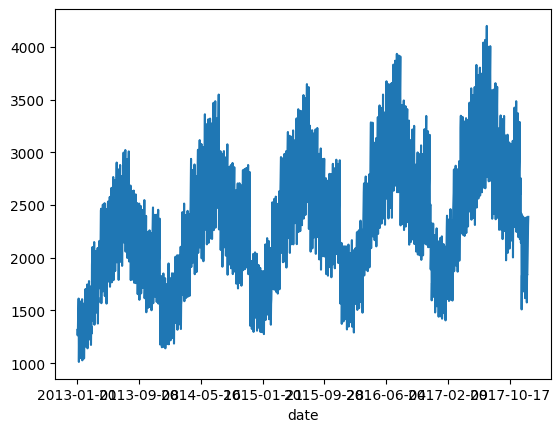

In [409]:
# univariate dataframe: sales vs Time
store_1_data = data[data['store'] == 1]
uni_data_df = store_1_data['sales']
uni_data_df.index = store_1_data['date']
uni_data_df.plot()
uni_data_df.head()

### Split de datos

In [410]:
print('inicio: ', uni_data_df.index.min())
print('final: ', uni_data_df.index.max())

inicio:  2013-01-01
final:  2017-12-31


Como termina en diciemre de 2017, necesitaremos que el conjunto de prueba abarque los datos de octubre, noviembre y diciembre.

In [411]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# 60 entreno, 20 test y 20 validacion
train_data, temp_data = train_test_split(data, test_size=0.4, random_state=42)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)


In [412]:
from datetime import datetime

train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])
validation_data['date'] = pd.to_datetime(validation_data['date'])

# Ordena los datos por la columna 'date'
train_data.sort_values(by='date', inplace=True)
test_data.sort_values(by='date', inplace=True)
validation_data.sort_values(by='date', inplace=True)

# Calcula la fecha de corte para el conjunto de prueba (3 meses antes de la última fecha)
last_date = uni_data_df.index.max()
last_date = datetime.strptime(last_date, '%Y-%m-%d')
test_cutoff_date = last_date - pd.DateOffset(months=3)

# Divide los datos en conjuntos de entrenamiento y prueba
test_set = test_data[test_data['date'] >= test_cutoff_date]

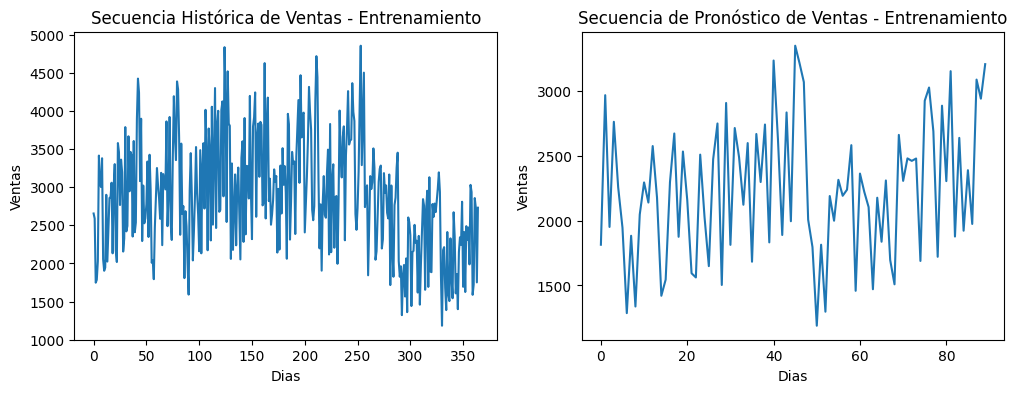

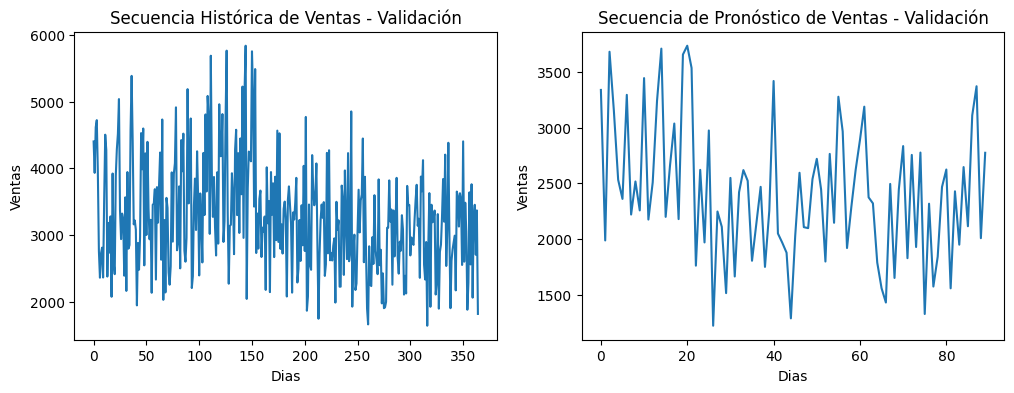

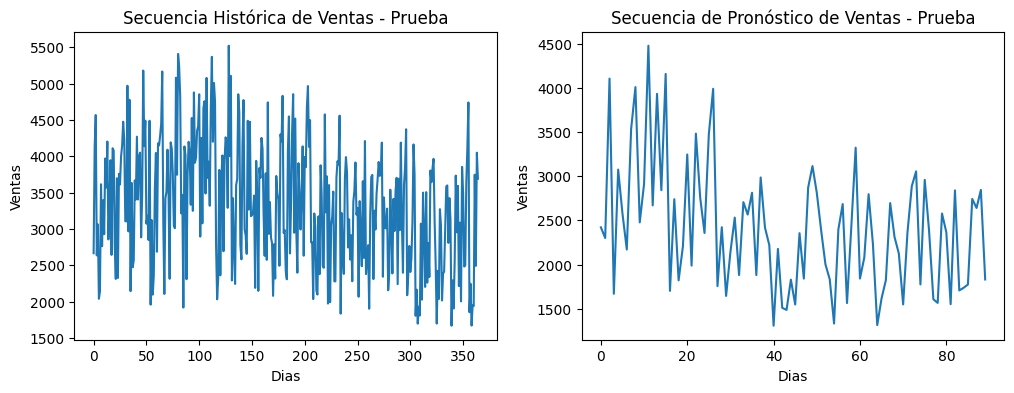

In [413]:
window_size = 365  # 12 meses de datos históricos
forecast_horizon = 90  # Pronóstico de 3 meses

# Función para crear secuencias y visualizar un ejemplo
def create_sequences_and_plot(data, set_name):
    sequences = []

    for i in range(len(data) - window_size - forecast_horizon + 1):
        historical_data = data.iloc[i:i+window_size]['sales'].values
        target = data.iloc[i+window_size:i+window_size+forecast_horizon]['sales'].values
        sequences.append((historical_data, target))

    # Visualizar un ejemplo (el primero)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(historical_data)), historical_data)
    plt.xlabel('Dias')
    plt.ylabel('Ventas')
    plt.title(f'Secuencia Histórica de Ventas - {set_name}')

    plt.subplot(1, 2, 2)
    plt.plot(range(len(target)), target)
    plt.xlabel('Dias')
    plt.ylabel('Ventas')
    plt.title(f'Secuencia de Pronóstico de Ventas - {set_name}')

    plt.show()

    return sequences

# Crea secuencias y visualiza un ejemplo para los conjuntos de entrenamiento, validación y prueba
train_sequences = create_sequences_and_plot(train_data, 'Entrenamiento')
validation_sequences = create_sequences_and_plot(validation_data, 'Validación')
test_sequences = create_sequences_and_plot(test_data, 'Prueba')

Aqui podemos ver el pronostico para 3 meses desde el historico de un año en la secuencia de tiempo. Con esto tomamos los datos de un año y teniendo esta informacion adelantamos a los siguientes 3 meses para observar la secuencia de los datos en el tiempo.

Para determinar si es más eficiente utilizar una LSTM, GRU o Conv1D vamos a observar las fortalezas de estos:
- LSTM puede determinar factories de patrones en las compras al paso del tiempo (tendencias, estaciones, etc)
- GRU puede modelar dependencias a largo plazo
- Conv1D detecta patrones locales en secuencias temporales.

### LSTM

In [414]:
num_features = 365

In [415]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model_lstm = Sequential()

# Capa LSTM con 50 unidades
model_lstm.add(LSTM(50, activation='relu', input_shape=(window_size, num_features)))

# Capa de Dropout para regularización
model_lstm.add(Dropout(0.2))

# Capa Densa para predicciones finales
model_lstm.add(Dense(forecast_horizon))

# Compilación del modelo
model_lstm.compile(optimizer='adam', loss='mean_squared_error')


In [416]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_prob):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob, return_sequences=False)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Tomamos la última salida de la secuencia
        return out

# Definir hiperparámetros
input_size = num_features  # Número de características de entrada
hidden_size = 50  # Tamaño del estado oculto
output_size = forecast_horizon  # Tamaño de la salida
num_layers = 1  # Número de capas LSTM
dropout_prob = 0.2  # Probabilidad de dropout

# Crear una instancia del modelo LSTM en PyTorch
model_lstm_pytorch = LSTMModel(input_size, hidden_size, output_size, num_layers, dropout_prob)


TypeError: RNNBase.__init__() got an unexpected keyword argument 'return_sequences'

## GRU

In [417]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

model_gru = Sequential()

# Capa GRU con 50 unidades
model_gru.add(GRU(50, activation='relu', input_shape=(window_size, num_features)))

# Capa de Dropout para regularización
model_gru.add(Dropout(0.2))

# Capa Densa para predicciones finales
model_gru.add(Dense(forecast_horizon))

# Compilación del modelo
model_gru.compile(optimizer='adam', loss='mean_squared_error')


In [418]:
class GRUModel(nn.Module):
    def __init(self, input_size, hidden_size, output_size, num_layers, dropout_prob):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # Tomamos la última salida de la secuencia
        return out

# Definir hiperparámetros
input_size = num_features  # Número de características de entrada
hidden_size = 50  # Tamaño del estado oculto
output_size = forecast_horizon  # Tamaño de la salida
num_layers = 1  # Número de capas GRU
dropout_prob = 0.2  # Probabilidad de dropout

# Crear una instancia del modelo GRU en PyTorch
model_gru_pytorch = GRUModel(input_size, hidden_size, output_size, num_layers, dropout_prob)

TypeError: GRUModel.__init__() takes 1 positional argument but 6 were given

## Conv1D

In [425]:
data.info

<bound method DataFrame.info of              date  store  sales
0      2013-01-01      1   1316
1      2013-01-01      2   1742
2      2013-01-01      3   1588
3      2013-01-01      4   1423
4      2013-01-01      5   1032
...           ...    ...    ...
18255  2017-12-31      6   2009
18256  2017-12-31      7   1831
18257  2017-12-31      8   3205
18258  2017-12-31      9   2774
18259  2017-12-31     10   2939

[18260 rows x 3 columns]>

In [419]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

model_conv1d = Sequential()

# Capa Conv1D con 32 filtros y ventana de 3
model_conv1d.add(Conv1D(32, 3, activation='relu', input_shape=(window_size, num_features)))

# Capa de MaxPooling1D para reducción
model_conv1d.add(MaxPooling1D(2))

# Capa de aplanado
model_conv1d.add(Flatten())

# Capa Densa con 50 unidades
model_conv1d.add(Dense(50, activation='relu'))

# Capa de Dropout para regularización
model_conv1d.add(Dropout(0.2))

# Capa Densa para predicciones finales
model_conv1d.add(Dense(forecast_horizon))

# Compilación del modelo
model_conv1d.compile(optimizer='adam', loss='mean_squared_error')


In [420]:
class Conv1DModel(nn.Module):
    def __init__(self, input_size, num_filters, kernel_size, output_size, hidden_size, dropout_prob):
        super(Conv1DModel, self).__init__()
        self.conv1d = nn.Conv1d(input_size, num_filters, kernel_size)
        self.max_pooling = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(num_filters, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Cambiar el orden de las dimensiones para Conv1D
        x = self.conv1d(x)
        x = self.max_pooling(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Definir hiperparámetros
input_size = num_features  # Número de características de entrada
num_filters = 32  # Número de filtros en la capa Conv1D
kernel_size = 3  # Tamaño del kernel
output_size = forecast_horizon  # Tamaño de la salida
hidden_size = 50  # Tamaño de la capa oculta
dropout_prob = 0.2  # Probabilidad de dropout

# Crear una instancia del modelo Conv1D en PyTorch
model_conv1d_pytorch = Conv1DModel(input_size, num_filters, kernel_size, output_size, hidden_size, dropout_prob)

Ahora entrenamos los modelos implementados

Evaluamos

Validamos